In [2]:
import uproot
import awkward as ak
import numpy as np
from glob import glob
from coffea.nanoevents import NanoEventsFactory, DelphesSchema

import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
plt.style.use(hep.style.ROOT)

In [8]:
import sys
sys.path.append('../yuzhe')
from custom import CustomDelphesSchema

In [23]:
# df = uproot.lazy('/data/bond/zhaoyz/Pheno/ntuplizer/output_with_b_tag/sm/TTbar_semilep_set3_25M/ntuple_events_delphes_454.root')
df = uproot.lazy('/data/bond/zhaoyz/Pheno/delphes/sm/TTbar_semilep_part1_25M/events_delphes_49.root')

In [24]:
ak.fields(df)

['Event',
 'Event.fUniqueID',
 'Event.fBits',
 'Event.Number',
 'Event.ReadTime',
 'Event.ProcTime',
 'Event.ProcessID',
 'Event.MPI',
 'Event.Weight',
 'Event.CrossSection',
 'Event.CrossSectionError',
 'Event.Scale',
 'Event.AlphaQED',
 'Event.AlphaQCD',
 'Event.ID1',
 'Event.ID2',
 'Event.X1',
 'Event.X2',
 'Event.ScalePDF',
 'Event.PDF1',
 'Event.PDF2',
 'Event_size',
 'Weight',
 'Weight.fUniqueID',
 'Weight.fBits',
 'Weight.Weight',
 'Weight_size',
 'Particle',
 'Particle.fUniqueID',
 'Particle.fBits',
 'Particle.PID',
 'Particle.Status',
 'Particle.IsPU',
 'Particle.M1',
 'Particle.M2',
 'Particle.D1',
 'Particle.D2',
 'Particle.Charge',
 'Particle.Mass',
 'Particle.E',
 'Particle.Px',
 'Particle.Py',
 'Particle.Pz',
 'Particle.P',
 'Particle.PT',
 'Particle.Eta',
 'Particle.Phi',
 'Particle.Rapidity',
 'Particle.T',
 'Particle.X',
 'Particle.Y',
 'Particle.Z',
 'Particle_size',
 'ParticleFlowCandidate',
 'ParticleFlowCandidate.fUniqueID',
 'ParticleFlowCandidate.fBits',
 'Partic

In [3]:
events = NanoEventsFactory.from_root(
    # '/data/bond/zhaoyz/Pheno/ntuplizer/output_with_b_tag/sm/TTbar_semilep_set3_25M/ntuple_events_delphes_454.root',
    '/data/bond/zhaoyz/Pheno/delphes/sm/TTbar_semilep_part1_25M/events_delphes_49.root',
    treepath='/Delphes',
    schemaclass=DelphesSchema,
).events()

In [21]:
typelist = ['ch+', 'ch-', 'nh', 'ph', 'el+', 'el-', 'mu+', 'mu-']

def make_subplot(ax, data, jet_data, fatjet_data, ele_data, mu_data, part_data, force_xylim=None, annotate_pid=False):
    # default plotting configuration
    color_dict_ = {'ch': 'C0', 'nh': 'mediumpurple', 'ph': 'orange', 'el': 'red', 'mu': 'green'}
    color_dict = color_dict_.copy()
    color_dict.update({k+'+': color_dict_[k] for k in color_dict_})
    color_dict.update({k+'-': color_dict_[k] for k in color_dict_})
    color_default =  'C0'
    ptdraw_fn = lambda pt: np.sqrt(pt)/40
    # if data.get('id') is None:
    #     data['id'] = ['default'] * len(data['pt'])
    if not hasattr(data, 'e'):
        for eta, phi, pt, id, d3d, pid in zip(data['eta'], data['phi'], data['pt'], data['id'], data['d3d'], data['pid']):
            ptdraw = ptdraw_fn(pt)
            alpha = 0.3
            if id in [4,5]:
                ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=ptdraw, clip_on=True, alpha=alpha, edgecolor='black', **make_color_args(id, d3d)))
            elif id in [6,7]:
                ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=ptdraw, orientation=np.pi, clip_on=True, alpha=alpha, edgecolor='black', **make_color_args(id, d3d)))
            elif id in [3]:
                ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 5, radius=ptdraw, clip_on=True, alpha=alpha, **make_color_args(id, d3d)))
            else:
                ax.add_patch(plt.Circle((eta, phi), ptdraw, clip_on=True, alpha=alpha, **make_color_args(id, d3d)))
            if annotate_pid:
                ax.text(eta, phi, f"{pid}:{pt:.0f}", ha='center', va='center', fontsize=10)
    else:
        for eta, phi, pt, e, id, d3d in zip(data['eta'], data['phi'], data['pt'], data['e'], data['id'], data['d3d']):
            ax.add_patch(mpl.patches.Wedge((eta, phi), pt/600., 90, 270, clip_on=True, alpha=alpha, **make_color_args(id, d3d)))
            ax.add_patch(mpl.patches.Wedge((eta, phi), e/600.,  270, 90, clip_on=True, alpha=alpha, **make_color_args(id, d3d)))
    
    # jet data
    for eta, phi, pt, flv in zip(jet_data['eta'], jet_data['phi'], jet_data['pt'], jet_data['flavour']):
        ax.add_patch(plt.Circle((eta, phi), 0.4, clip_on=True, alpha=0.5, edgecolor='orange', fill=False))
        # ax.text(eta, phi, f"{pt:.0f}", ha='center', va='center', fontsize=10)
        ax.text(eta, phi+0.35, f"flv={flv}", ha='center', va='center', fontsize=10, style='italic', color='brown')

    # fatjet data
    for eta, phi, pt in zip(fatjet_data['eta'], fatjet_data['phi'], fatjet_data['pt']):
        ax.add_patch(plt.Circle((eta, phi), 0.8, clip_on=True, alpha=0.5, edgecolor='brown', fill=False))
        # ax.text(eta, phi, f"{pt:.0f}", ha='center', va='center', fontsize=10)
    
    # electron and muons
    for eta, phi, pt in zip(ele_data['eta'], ele_data['phi'], ele_data['pt']):
        ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=ptdraw_fn(pt), clip_on=True, alpha=alpha, edgecolor='black', facecolor='purple'))
    for eta, phi, pt in zip(mu_data['eta'], mu_data['phi'], mu_data['pt']):
        ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=ptdraw_fn(pt), orientation=np.pi, clip_on=True, alpha=alpha, edgecolor='black', facecolor='purple'))

    # custom particles
    for i, (eta, phi, pt, pid) in enumerate(zip(part_data['eta'], part_data['phi'], part_data['pt'], part_data['pid'])):
        ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 4, radius=0.1, orientation=0, clip_on=True, alpha=alpha/1.5, facecolor=f'C{i}'))
        ax.text(eta, phi, f"{pid}", ha='center', va='center', fontsize=10)
    # custom particle connections
    connections = [(0, 1), (0, 2), (1, 3), (1, 4), (5, 6), (5, 7), (6, 8), (6, 9)]
    for a, b in connections:
        # draw an arrow
        ax.arrow(part_data['eta'][a], part_data['phi'][a], part_data['eta'][b]-part_data['eta'][a], part_data['phi'][b]-part_data['phi'][a], head_width=0.1, head_length=0.1, color=f'C{a}', alpha=alpha)

    max_ang = force_xylim if force_xylim else max(max(abs(data['eta'])), max(abs(data['phi'])))
    # make square plot centered at (0,0)
    ax.set_xlim(-max_ang, max_ang); ax.set_ylim(-max_ang, max_ang)
    ax.set_xlabel(r'$\Delta\eta$'); ax.set_ylabel(r'$\Delta\phi$')
    ax.set_aspect('equal')
    return max_ang

def make_color_args(id, d3d):
    # color = color_fader('C0', 'magenta', d3d)
    # color = color_fader('#a8ddb5', '#084081', d3d)
    color = color_fader('#74c476', '#081d58', d3d)
    # color = color_fader('seagreen', 'darkblue', d3d)
    if id in [2, 3]:
        return {'edgecolor': color, 'linewidth': 1, 'fill': False}
    else:
        return {'facecolor': color}
    # if id in [1, 5, 7]:
    #     return {'edgecolor': color, 'fill': False, 'hatch':'**'}
    # else:
    #     return {'facecolor': color}

def color_fader(c1, c2, mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    mix = min(1., mix)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [26]:
## unified PFCands delphes card
i = 17
evt = events[i]

obj_arr_dict = {}
obj = evt.ParticleFlowCandidate
jet = evt.JetPUPPI
fatjet = evt.JetPUPPIAK8
ele = evt.Electron
mu = evt.Muon
part = evt.Particle

obj_arr = ak.zip(dict(
    pt=obj.PT,
    eta=obj.Eta,
    phi=obj.Phi,
    # energy=obj.energy,
    id=ak.argmax(np.transpose(np.stack([
            ((abs(obj.PID) >= 100) & (abs(obj.PID) <= 999)) & (obj.Charge == 1),
            ((abs(obj.PID) >= 100) & (abs(obj.PID) <= 999)) & (obj.Charge == -1),
            ((abs(obj.PID) >= 100) & (abs(obj.PID) <= 999)) & (obj.Charge == 0),
            (obj.PID == 22),
            (obj.PID == 11),
            (obj.PID == -11),
            (obj.PID == 13),
            (obj.PID == -13),
        ])), axis=1),
    d3d=np.hypot(obj.D0, (obj.DZ - evt.Vertex[0].Z)*(obj.DZ != 0)), # for pileup, should mitigate the vertex Z value
    # d3d=np.hypot(obj.D0, obj.DZ),
    pid=obj.PID,
))
jet_arr = ak.zip(dict(pt=jet.PT, eta=jet.Eta, phi=jet.Phi, flavour=jet.Flavor))
fatjet_arr = ak.zip(dict(pt=fatjet.PT, eta=fatjet.Eta, phi=fatjet.Phi))
ele_arr = ak.zip(dict(pt=ele.PT, eta=ele.Eta, phi=ele.Phi))
mu_arr = ak.zip(dict(pt=mu.PT, eta=mu.Eta, phi=mu.Phi))

### particle arrays
part_sel = []
p_t = part[(part.PID == 6) & (part.Status == 62)][-1]
p_tbar = part[(part.PID == -6) & (part.Status == 62)][-1]
p_wp = part[(part.PID == 24)][-1]
p_wm = part[(part.PID == -24)][-1]
part_sel.append(p_t)
part_sel.append(part[p_t.D1])
part_sel.append(part[p_t.D2])
part_sel.append(part[p_wp.D1])
part_sel.append(part[p_wp.D2])
part_sel.append(p_tbar)
part_sel.append(part[p_tbar.D1])
part_sel.append(part[p_tbar.D2])
part_sel.append(part[p_wm.D1])
part_sel.append(part[p_wm.D2])
part_arr = ak.zip(dict(
    pt=ak.Array([p.PT for p in part_sel]),
    eta=ak.Array([p.Eta for p in part_sel]),
    phi=ak.Array([p.Phi for p in part_sel]),
    pid=ak.Array([p.PID for p in part_sel])
))

5

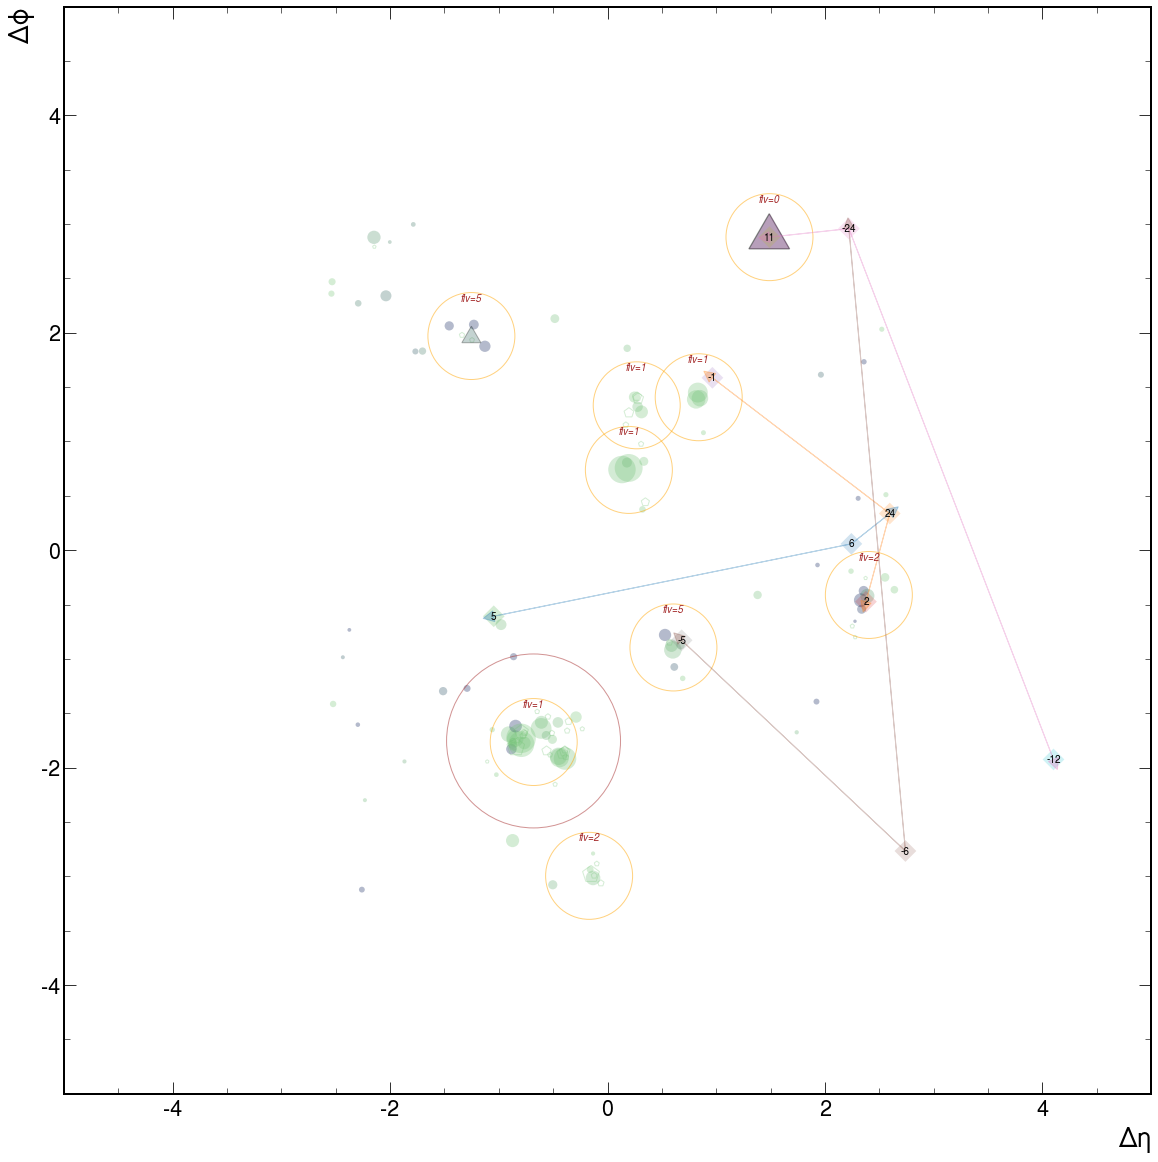

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))
make_subplot(ax, obj_arr, jet_arr, fatjet_arr, ele_arr, mu_arr, part_arr, force_xylim=5)